### Selective Search

In [ ]:
import argparse
import random
import time
import cv2
import matplotlib.pyplot as plt

fast = False

# load the input image
image = cv2.imread("../scratch_data/2.png")
# initialize OpenCV's selective search implementation and set the
# input image
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
# check to see if we are using the *fast* but *less accurate* version
# of selective search
if fast:
    print("[INFO] using *fast* selective search")
    ss.switchToSelectiveSearchFast()
# otherwise we are using the *slower* but *more accurate* version
else:
    print("[INFO] using *quality* selective search")
    ss.switchToSelectiveSearchQuality()

# run selective search on the input image
start = time.time()
rects = ss.process()
end = time.time()

# show how along selective search took to run along with the total
# number of returned region proposals
print("[INFO] selective search took {:.4f} seconds".format(end - start))
print("[INFO] {} total region proposals".format(len(rects)))




In [ ]:
#loop over the region proposals in chunks (so we can better visualize them)
for i in range(0, 100, 100):
    # clone the original image so we can draw on it
    output = image.copy()
    # loop over the current subset of region proposals
    for (x, y, w, h) in rects[i:i + 700]:
        # draw the region proposal bounding box on the image
        color = [random.randint(0, 255) for j in range(0, 3)]
        cv2.rectangle(output, (x, y), (x + w, y + h), color, 2)
    # show the output image
    plt.figure(figsize=(10, 10))
    plt.title("Selective Search")
    plt.imshow(output)
    # cv2.imshow("Output", output)



### Thresholding

In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import os

out_folder = '/Users/matt/Desktop'
img = cv2.imread("../scratch_data/2_cropped.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv.medianBlur(img,5)
ret,th1 = cv.threshold(img,90,255,cv.THRESH_BINARY)
th2 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY,55,-3)
th3 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,11,2)
th3 = 255 - th3
titles = ['Original Image', 'Global Thresholding (v = 50)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img, th1, th2, th3]
names = ['original', 'basic', 'mean', 'gaussian']
plt.figure(figsize=(15, 15))

grey_col = np.stack([img] * 3, axis=-1)

for i in range(4):
    overlay = np.copy(grey_col)
    plt.subplot(2,2,i+1)
    if i > 0:
        overlay[images[i] == 255] =  [230,0,255]
        plt.imshow(overlay)
    else:
        plt.imshow(images[0],'gray')
        # plt.imshow(images[i], 'jet', alpha=0.5)
    # Create a PIL image from the array
    pil_im = Image.fromarray(overlay)

    # Save the image as a PNG file
    # pil_im.save(os.path.join(out_folder, names[i] + '.png'))

    plt.xticks([]),plt.yticks([])
plt.tight_layout()
plt.show()



### Edge Detection

In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

def edge_detect(image):

    # Intro
    scale = 1
    delta = 0
    ddepth = cv.CV_16S
    ksize = 3

    # Read image
    src = cv.imread(image, cv.IMREAD_COLOR)

    # Display source image
    plt.figure()
    plt.title("Original image")
    plt.imshow(src)

    # Apply Gaussian Blur and greyscale
    src = cv.GaussianBlur(src, (3, 3), 0)
    gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY)

    # Sobel filter
    grad_x = cv.Sobel(gray, ddepth, 1, 0, ksize=ksize, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)
    # Gradient-Y
    # grad_y = cv.Scharr(gray,ddepth,0,1)
    grad_y = cv.Sobel(gray, ddepth, 0, 1, ksize=ksize, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)
    abs_grad_x = cv.convertScaleAbs(grad_x)
    abs_grad_y = cv.convertScaleAbs(grad_y)
    grad = cv.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

    # Show Sobel result
    plt.figure()
    plt.title("Sobel Filter")
    plt.imshow(grad)

    pil_im = Image.fromarray(grad)
    pil_im.save(os.path.join(out_folder, 'sobel.png'))

    # Scharr filter
    grad_x = cv.Scharr(gray, ddepth, 1, 0, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)
    # Gradient-Y
    grad_y = cv.Scharr(gray, ddepth, 0, 1, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)
    abs_grad_x = cv.convertScaleAbs(grad_x)
    abs_grad_y = cv.convertScaleAbs(grad_y)
    grad2 = cv.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    # Show Scharr result
    plt.figure()
    plt.title("Scharr Filter")
    plt.imshow(grad2)

    pil_im = Image.fromarray(grad2)
    pil_im.save(os.path.join(out_folder, 'scharr.png'))

    # Use Canny edge detection (Sobel is in this already)
    edges = cv.Canny(gray,30,60)
    plt.figure()
    plt.title("Canny Edge Detection")
    plt.imshow(edges)

    grey_col = np.stack([gray] * 3, axis=-1)
    grey_col[edges == 255] =  [230,0,255]

    pil_im = Image.fromarray(grey_col)
    pil_im.save(os.path.join(out_folder, 'canny.png'))


    return grad, grad2, edges

out_folder = '/Users/matt/Desktop'
grad, grad2, edges = edge_detect("../scratch_data/2_cropped.png")


### Region Segmentation Testing


In [ ]:
from gel_tools import GelAnalysis
from PIL import Image
import matplotlib.pyplot as plt

import numpy as np


reps = 1


analyser = GelAnalysis("../scratch_data/2_cropped.png", image_type='file')
bg = analyser.get_otsu_threshold()
fg = bg + 25
analyser.find_bands(fg, bg, reps)
print(bg)

In [ ]:
for bg in [10,20,35,45,55,70]:
    fg = bg + 25
    analyser.find_bands(fg, bg, reps)
    plt.figure(figsize=(10, 10))
    plt.imshow(analyser.overlayed_image_bands)
    plt.xticks([]),plt.yticks([])
    pass

In [ ]:
bg = 20
reps = 1
for fg in [25, 30, 35, 40, 45, 50, 70]:
    analyser.find_bands(fg, bg, reps)
    plt.figure(figsize=(10, 10))
    plt.imshow(analyser.overlayed_image_bands)
    plt.xticks([]), plt.yticks([])
    pass

In [ ]:
from gel_tools.band_detection import find_bands
import os
analyser = GelAnalysis("../scratch_data/2_cropped.png", image_type='file')
out_folder = '/Users/matt/Desktop'
bg = analyser.get_otsu_threshold()
bg = 35
for index, reps in enumerate([1,2,3,4]):
    fg = bg + 25
    overlayed_image_bands, _, _, _, _ = \
            find_bands(analyser.gray_image, int(fg) / 100 * 65535, int(bg) / 100 * 65535, int(reps), background_jump=0.1, minimum_pixel_count=50)
    plt.figure(figsize=(10, 10))
    plt.imshow(overlayed_image_bands)
    plt.xticks([]), plt.yticks([])
    conv_array = (overlayed_image_bands*255).astype(np.uint8)
    pil_im = Image.fromarray(conv_array)

    # Save the image as a PNG file
    # pil_im.save(os.path.join(out_folder, 'rep_%s.png' % reps))


In [ ]:
from gel_tools import GelAnalysis
from gel_tools.band_detection import find_bands
import os

analyser = GelAnalysis("../scratch_data/2_cropped.png", image_type='file')
out_folder = '/Users/matt/Desktop'
bg = analyser.get_otsu_threshold()
bg = 35
for index, reps in enumerate([4]):
    fg = bg + 25
    overlayed_image_bands, props, overlay_inverted, props_table, labeled_fbands = \
    find_bands(analyser.gray_image, int(fg) / 100 * 65535, int(bg) / 100 * 65535, int(reps), background_jump=0.1,
                   minimum_pixel_count=50)
    plt.figure(figsize=(10, 10))
    plt.imshow(overlayed_image_bands)
    plt.xticks([]), plt.yticks([])
    conv_array = (overlayed_image_bands * 255).astype(np.uint8)
    pil_im = Image.fromarray(conv_array)

    # Save the image as a PNG file
    # pil_im.save(os.path.join(out_folder, 'rep_%s.png' % reps))


In [ ]:
markers = np.ones_like(analyser.gray_image) * 120
bg = 35
fg = bg + 25

markers[analyser.gray_image < (bg / 100) * 65535] = 0
markers[analyser.gray_image > (fg / 100) * 65535] = 255
markers = 255 - markers
fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
plt.imshow(markers, cmap='Purples')
plt.axis('off')
# plt.tight_layout()
plt.savefig('/Users/matt/Desktop/markers.png', dpi=300)


### Main thesis images here

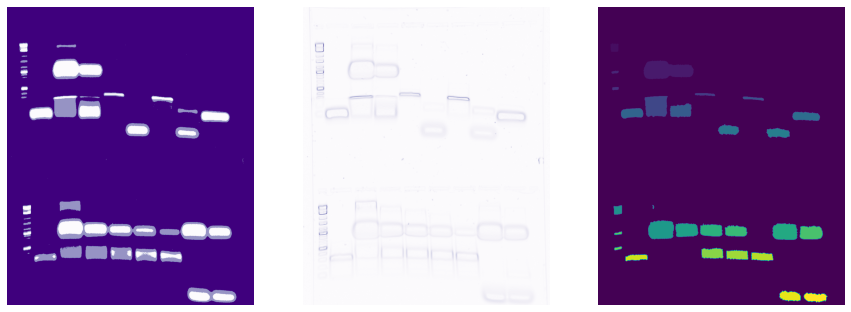

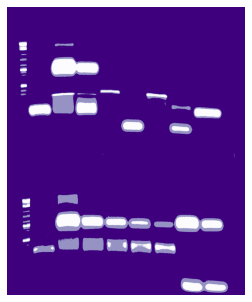

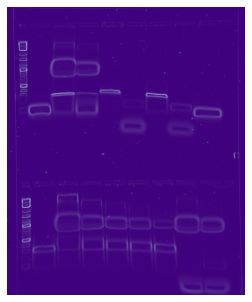

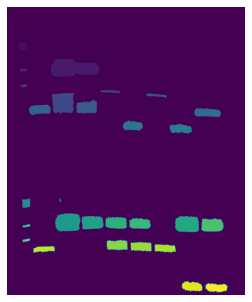

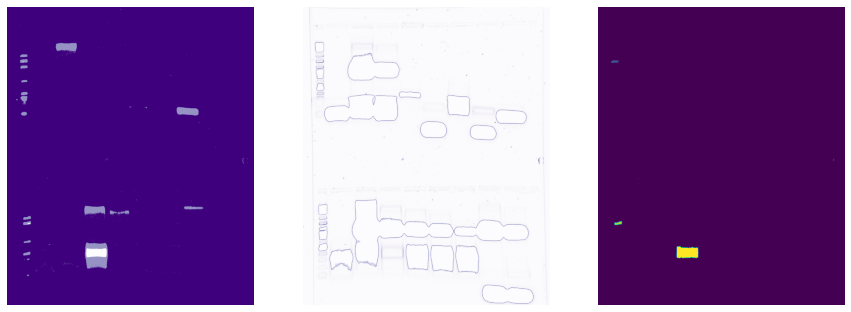

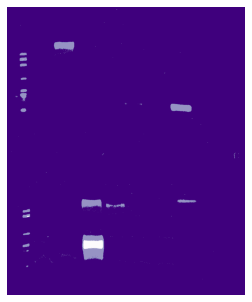

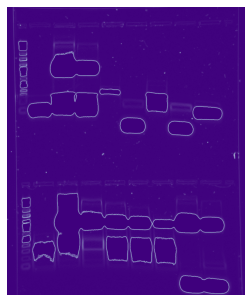

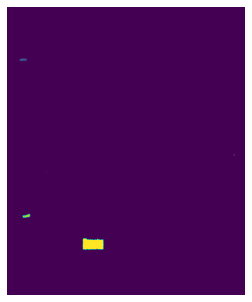

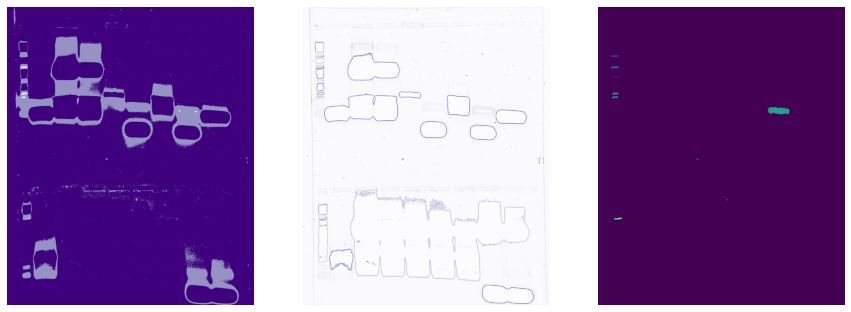

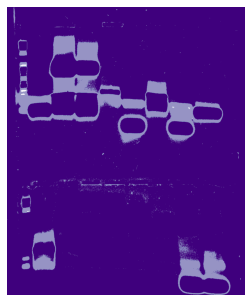

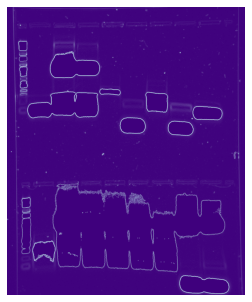

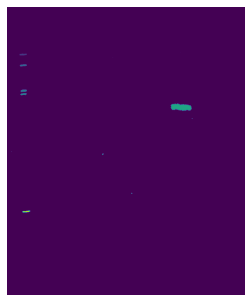

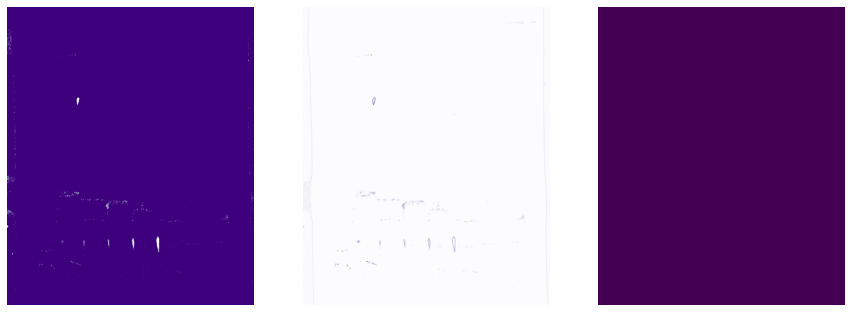

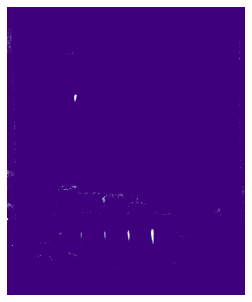

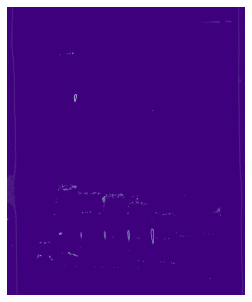

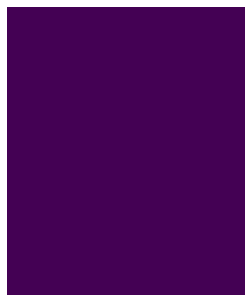

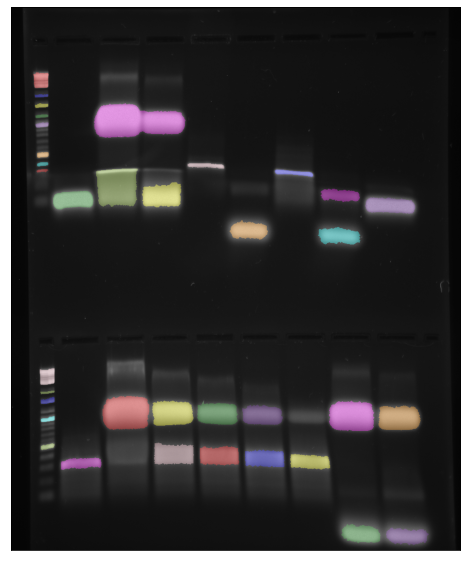

In [6]:
from gel_tools.band_detection import watershed_seg, mask_expansion
import skimage
import skimage.util as util
from scipy import ndimage as ndi
from skimage.color import label2rgb
from skimage.filters import sobel

from gel_tools import GelAnalysis
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def watershed_seg_direct(image, sure_fg, sure_bg, verbose=False):
    """
    Apply watershed algorithm to find bands in a given image.
    :param image: numpy array containing image raw data (grayscale, 16-bit)
    :param sure_fg: Threshold value above which a band is definitely present.
    :param sure_bg: Threshold value under which a band is definitely not present.
    :param verbose:  Set to true to print out figures containing results immediately.
    :return: 2D array of same shape as orig. image with unique band labels
    """

    global global_sobel

    # Use Sobel filter on original image to find elevation map
    elevation_map = sobel(image)

    # Define markers for the background and foreground of the image
    markers = np.zeros_like(image)
    markers[image < sure_bg] = 1
    markers[image > sure_fg] = 2

    markers_plot = np.ones_like(image) * 120

    markers_plot[image < sure_bg] = 0
    markers_plot[image > sure_fg] = 255
    markers_plot = 255 - markers_plot
    # Apply the watershed algorithm itself, using the elevation map and markers
    segmentation = skimage.segmentation.watershed(elevation_map, markers)

    # Fill holes and relabel bands, giving each a unique label
    segmentation = ndi.binary_fill_holes(segmentation - 1)
    labeled_bands, _ = ndi.label(segmentation)

    # Overlay labels on original image
    image_label_overlay = label2rgb(labeled_bands, image=image)

    if verbose:
        plt.figure()
        plt.title("Region-based Segmentation")
        plt.imshow(image_label_overlay)
        print('Band Labels:')
        print(labeled_bands)

    fig,ax = plt.subplots(1,3,figsize=(15, 10))
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    ax[0].imshow(markers_plot, cmap='Purples')
    ax[1].imshow(elevation_map, cmap='Purples')
    ax[2].imshow(labeled_bands)

    for out_array, label in zip([markers_plot, elevation_map, labeled_bands],['markers', 'sobel_elevation', 'accepted_markers']):
        fig = plt.figure(frameon=False)
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)

        if label == 'accepted_markers':
            plt.imshow(out_array)
        elif label == 'sobel_elevation':
            plt.imshow(out_array, cmap='Purples_r')
        else:
            plt.imshow(out_array, cmap='Purples')
        plt.axis('off')
        plt.savefig(os.path.join(out_folder, '%s_%s.png' % (label, global_iter)), dpi=300)

    return labeled_bands


def find_bands_direct(img, sure_fg, sure_bg, repetitions, background_jump=0.005, verbose=False, minimum_pixel_count=50):
    """
    # Function which brings it all together and actually finds bands.
    # Takes the source image and watershed segmentation algorithm parameters.
    # Returns white-on-black and black-on-white images with colored bands, and band properties.
    """
    global global_iter

    if verbose:
        print('Band Finding Parameters:')
        print("sure fg: ", sure_fg)
        print("sure bg: ", sure_bg)
        print("repetitions: ", repetitions)
        print("===============")

    # Create copy of loaded image to apply mask to
    working_img = img.copy()

    # Create template for labels (each integer label corresponds to band ID)
    final_segmentation = np.zeros_like(img, dtype="int32")

    if img.dtype == 'uint16':
        max_pixel_val = 65535
    else:
        max_pixel_val = 255

    # Repeat the watershed algorithm "repetitions" times
    for i in range(0, repetitions):
        # Run watershed algorithm
        global_iter = i
        segmented_image = watershed_seg_direct(working_img, sure_fg, sure_bg)

        # Add found bands from this iteration to all found bands
        final_segmentation += segmented_image

        # Create mask
        mask = mask_expansion(working_img, segmented_image,  next_bg=sure_bg-background_jump*max_pixel_val)

        # Apply mask (removing areas of image which should no longer be explored)
        working_img[mask > 0] = 0

        if verbose:
            plt.figure()
            plt.title("Remaining parts of image without bands after repetition %d" % i)
            plt.imshow(working_img)

        # Reduce fg and bg values on each pass
        sure_fg -= background_jump*max_pixel_val
        sure_bg -= background_jump*max_pixel_val

    # Relabel bands to ensure correct labelling
    labeled_fbands, _ = ndi.label(final_segmentation)

    actual_band_id = 1
    for i in range(1, labeled_fbands.max()+1):  # filtering step - removes all segmented sections which are too small to be usable
        if (labeled_fbands == i).sum() < minimum_pixel_count:
            labeled_fbands[labeled_fbands == i] = 0
        else:
            labeled_fbands[labeled_fbands == i] = actual_band_id
            actual_band_id += 1

    # Overlay found bands on original image
    final_overlay = label2rgb(labeled_fbands, image=img, bg_label=0, bg_color=[0, 0, 0])  # TODO: does this always assume one type of image?

    if verbose:
        plt.figure()
        plt.title("Overlayed image")
        plt.imshow(final_overlay)

    # Invert image
    inverted_img = util.invert(img)
    # Overlay found bands on inverted image
    overlay_inverted = label2rgb(labeled_fbands, image=inverted_img, bg_label=0, bg_color=[1, 1, 1])

    # Find properties of bands
    props = skimage.measure.regionprops(labeled_fbands, img)
    props_table = skimage.measure.regionprops_table(labeled_fbands, img)

    return final_overlay, props, overlay_inverted, props_table, labeled_fbands


analyser = GelAnalysis("../scratch_data/2_cropped.png", image_type='file')
out_folder = '/Users/matt/Desktop'
bg = analyser.get_otsu_threshold()
bg = 35

for index, reps in enumerate([4]):
    fg = bg + 25
    overlayed_image_bands, props, overlay_inverted, props_table, labeled_fbands = \
    find_bands_direct(analyser.gray_image, int(fg) / 100 * 65535, int(bg) / 100 * 65535, int(reps), background_jump=0.1,
                   minimum_pixel_count=50)
    plt.figure(figsize=(10, 10))
    plt.imshow(overlayed_image_bands)
    plt.xticks([]), plt.yticks([])
    conv_array = (overlayed_image_bands * 255).astype(np.uint8)
    pil_im = Image.fromarray(conv_array)
    pil_im.save(os.path.join(out_folder, 'rep_%s.png' % reps))



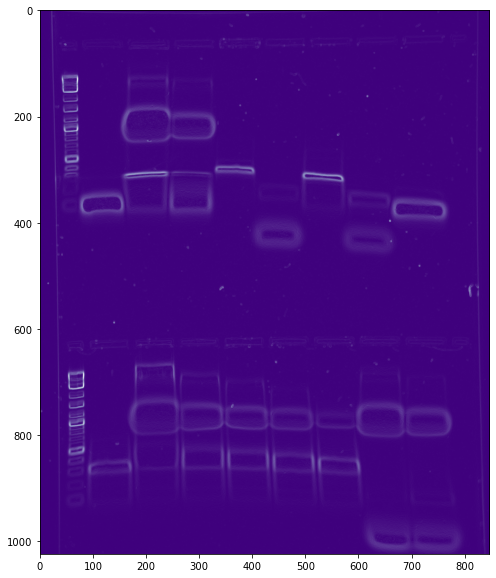

In [5]:
plt.figure(figsize=(10,10))
plt.imshow(global_sobel, cmap='Purples_r')

### Other tests

In [ ]:
import numpy as np
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage import measure
from skimage.segmentation import random_walker
import matplotlib.pyplot as plt
from scipy import ndimage

# Generate an initial image with two overlapping circles
x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 16, 20
mask_circle1 = (x - x1) ** 2 + (y - y1) ** 2 < r1 ** 2
mask_circle2 = (x - x2) ** 2 + (y - y2) ** 2 < r2 ** 2
image = np.copy(analyser.gray_image)
# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance
# to the background
bg = 35
mx = np.copy(image)
mx[analyser.gray_image < (bg / 100) * 65535] = 0

distance = ndimage.distance_transform_edt(mx)
local_maxi = peak_local_max(
    distance, indices=False, footprint=np.ones((3, 3)), labels=mx)
markers = measure.label(local_maxi)
labels_ws = watershed(-distance, markers, mask=mx)

plt.imshow(labels_ws, cmap='nipy_spectral', interpolation='nearest')

#
# markers[~mx] = -1
# labels_rw = random_walker(image, markers)
#
# plt.figure(figsize=(12, 3.5))
# plt.subplot(141)
# plt.imshow(image, cmap='gray', interpolation='nearest')
# plt.axis('off')
# plt.title('image')
# plt.subplot(142)
# plt.imshow(-distance, interpolation='nearest')
# plt.axis('off')
# plt.title('distance map')
# plt.subplot(143)
# plt.imshow(labels_ws, cmap='nipy_spectral', interpolation='nearest')
# plt.axis('off')
# plt.title('watershed segmentation')
# plt.subplot(144)
# plt.imshow(labels_rw, cmap='nipy_spectral', interpolation='nearest')
# plt.axis('off')
# plt.title('random walker segmentation')
#
# plt.tight_layout()
# plt.show()


In [ ]:
plt.imshow(labels_ws, cmap='nipy_spectral', interpolation='nearest')

In [ ]:
from gel_tools.band_detection import find_bands
import os
from gel_tools import GelAnalysis
import matplotlib.pyplot as plt
from PIL import Image

out_folder = '/Users/matt/Desktop'

images_to_test = ['gel_1_biodoc_2.tif', 'gel_1_biodoc.tif']

for image in images_to_test:
    analyser = GelAnalysis(os.path.join('../scratch_data', image), image_type='file')
    bg = analyser.get_otsu_threshold()
    for index, reps in enumerate([1]):
        fg = bg + 25
        overlayed_image_bands, _, _, _, _ = \
            find_bands(analyser.gray_image, int(fg) / 100 * 65535, int(bg) / 100 * 65535, int(reps), background_jump=0.1,
                       minimum_pixel_count=50)
        plt.figure(figsize=(10, 10))
        plt.imshow(overlayed_image_bands)
        plt.xticks([]), plt.yticks([])

    conv_array = (overlayed_image_bands * 255).astype(np.uint8)
    pil_im = Image.fromarray(conv_array)

    # Save the image as a PNG file
    pil_im.save(os.path.join(out_folder, '%s.png' % image.split('.')[0]))


In [ ]:
from gel_tools.band_detection import find_bands
import os
from gel_tools import GelAnalysis
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

out_folder = '/Users/matt/Desktop'

images_to_test = ['2_origami.tif', 'tbe_2_2_lod_v6.tif']

images_to_test = ['tbe_2_2_lod_v6.tif']

for image in images_to_test:
    analyser = GelAnalysis(os.path.join('../scratch_data', image), image_type='file')
    bg = analyser.get_otsu_threshold()
    for index, reps in enumerate([1]):
        fg = bg + 25
        overlayed_image_bands, _, _, _, _ = \
            find_bands(analyser.gray_image, int(fg) / 100 * 65535, int(bg) / 100 * 65535, int(reps),
                       background_jump=0.1,
                       minimum_pixel_count=50)
        plt.figure(figsize=(10, 10))
        plt.imshow(overlayed_image_bands)
        plt.xticks([]), plt.yticks([])

    conv_array = (overlayed_image_bands * 255).astype(np.uint8)
    pil_im = Image.fromarray(conv_array)

    # Save the image as a PNG file
    pil_im.save(os.path.join(out_folder, '%s.png' % image.split('.')[0]))


In [ ]:
from gel_tools.band_detection import find_bands
import os
from gel_tools import GelAnalysis
import matplotlib.pyplot as plt
from PIL import Image

out_folder = '/Users/matt/Desktop'
images_to_test = ['2_fractionation.tif', '1_fractionation.tif', '1_ruler.tif', '2_ruler.tif']

for image in images_to_test:
    analyser = GelAnalysis(os.path.join('../scratch_data', image), image_type='file')
    bg = analyser.get_otsu_threshold()
    for index, reps in enumerate([3]):
        fg = bg + 25
        overlayed_image_bands, _, _, _, _ = \
            find_bands(analyser.gray_image, int(fg) / 100 * 65535, int(bg) / 100 * 65535, int(reps),
                       background_jump=0.1,
                       minimum_pixel_count=50)
        plt.figure(figsize=(10, 10))
        plt.imshow(overlayed_image_bands)
        plt.xticks([]), plt.yticks([])

    conv_array = (overlayed_image_bands * 255).astype(np.uint8)
    pil_im = Image.fromarray(conv_array)

    # Save the image as a PNG file
    pil_im.save(os.path.join(out_folder, '%s.png' % image.split('.')[0]))


In [ ]:
import os
from gel_tools import GelAnalysis
import matplotlib.pyplot as plt
from PIL import Image

out_folder = '/Users/matt/Desktop'
images_to_test = ['2_cropped.png']

for image in images_to_test:
    analyser = GelAnalysis(os.path.join('../scratch_data', image), image_type='file')




z = analyser.gray_image.flatten()

plt.hist(z, 255)
